In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import random
from scipy.stats import pearsonr
seed = 42
torch.manual_seed(seed)  # For PyTorch CPU
torch.cuda.manual_seed(seed)  # For PyTorch GPU (if available)
np.random.seed(seed)  # For NumPy
random.seed(seed)  # For Python's random module
torch.backends.cudnn.deterministic = True  # For reproducibility on GPUs
torch.backends.cudnn.benchmark = False  # Make sure cudnn is deterministic
        # Split data into train and test sets for validation during training


os.makedirs("learning_curves", exist_ok=True)

# Load and prepare data
data = pd.read_csv("merged_data.csv")
data = data.dropna()

# Rename columns to handle case sensitivity
data = data.rename(columns={'pid': 'PID', 'Time': 'time'})

# Convert time to datetime
data['time'] = pd.to_datetime(data['time'], unit='ms')

# Verify PID column exists
if 'PID' not in data.columns:
    raise ValueError("PID column not found in data. Available columns: " + ", ".join(data.columns))

# Create time index for each PID group
data['time_index'] = data.groupby('PID').cumcount()

# Select features and target (we'll predict TAC_Reading)
X = data[['Pe_results', 'Comp_results']].values  # Features
y = data['TAC_Reading'].values  # Target (TAC_Reading)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Reshape for regression

# Move data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor, y_tensor = X_tensor.to(device), y_tensor.to(device)

# Create sequential batches
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data)-seq_length):
        sequences.append(data[i:i+seq_length])
    return torch.stack(sequences)

# Example usage for LSTM:
seq_length = 10  # Look at past 10 readings
X_seq = create_sequences(X_tensor, seq_length)
y_seq = y_tensor[seq_length-1:]  # Align targets

# ===================== Model Definitions (Same as Before) ===================== #
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class RNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=16, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class LSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=16, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class CNN(nn.Module):
    def __init__(self, input_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=1, stride=1)
        self.pool = nn.MaxPool1d(kernel_size=1)
        self.fc1 = nn.Linear(16 * input_size, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize models
input_size = X.shape[1]
models = {
    'FNN': FNN().to(device),
    'RNN': RNN().to(device),
    'LSTM': LSTM().to(device),
    'CNN': CNN(input_size).to(device)
}



def train_model_with_validation(model, X_train, y_train, X_test, y_test, model_name, epochs, lr=0.001):
    model_folder = f'model_{model_name}_{epochs}_epochs'
    os.makedirs(model_folder, exist_ok=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses, test_losses, total_losses = [], [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        train_loss = criterion(outputs, y_train)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

        total_loss = (
            train_loss.item() * len(X_train) +
            test_loss.item() * len(X_test)
        ) / (len(X_train) + len(X_test))
        total_losses.append(total_loss)

    # Save losses
    losses_df = pd.DataFrame({
        'epoch': range(epochs),
        'train_loss': train_losses,
        'test_loss': test_losses,
        'total_loss': total_losses
    })
    losses_df.to_csv(f'{model_folder}/losses.csv', index=False)

    # Save model weights
    torch.save(model.state_dict(), f'{model_folder}/{model_name}.pth')

    # Save learning curve plot
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.plot(total_losses, label='Total Loss')
    plt.title(f'Learning Curve - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_folder}/learning_curves.png')
    plt.close()

    return train_losses, test_losses, total_losses, model_folder


def plot_separate_loss_curves(model_names):
    """Plot separate curves with improved titles for generalization performance"""
    
    # Plot 1: Train Loss
    plt.figure(figsize=(12, 6))
    for model_name in model_names:
        try:
            curve_data = pd.read_csv(f'learning_curves/{model_name}_learning_curve.csv')
            plt.plot(curve_data['epoch'], curve_data['train_loss'], label=f'{model_name} Train Loss')
        except FileNotFoundError:
            print(f"Warning: Train loss data not found for {model_name}")
    plt.title("Train Generalization Performance Over Epochs")
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('learning_curves/train_loss_all_models.png')
    plt.show()
    
    # Plot 2: Test Loss
    plt.figure(figsize=(12, 6))
    for model_name in model_names:
        try:
            curve_data = pd.read_csv(f'learning_curves/{model_name}_learning_curve.csv')
            plt.plot(curve_data['epoch'], curve_data['test_loss'], label=f'{model_name} Test Loss')
        except FileNotFoundError:
            print(f"Warning: Test loss data not found for {model_name}")
    plt.title("Test Generalization Performance Over Epochs")
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('learning_curves/test_loss_all_models.png')
    plt.show()


def plot_predictions_with_boundary(y_train, y_test, y_pred, model_name):
    # Move to CPU and flatten if needed
    y_train = y_train.detach().cpu().numpy().flatten()
    y_test = y_test.detach().cpu().numpy().flatten()
    y_pred = y_pred.detach().cpu().numpy().flatten()

    # Combine train and test ground truth
    y_true_all = np.concatenate([y_train, y_test])
    n_train = len(y_train)
    n_total = len(y_true_all)

    # Prepare x-axis
    x = np.arange(n_total)

    plt.figure(figsize=(14, 6))
    plt.plot(x, y_true_all, label='True TAC Reading', color='gray', alpha=0.6)
    plt.axvline(x=n_train, color='black', linestyle='--', label='Train/Test Split')
    plt.plot(x[n_train:], y_test, label='True (Test Set)', color='blue')
    plt.plot(x[n_train:], y_pred, label='Predicted (Test Set)', color='red')

    plt.title(f"{model_name} Generalization Prediction vs True TAC Reading")
    plt.xlabel('Sample Index')
    plt.ylabel('TAC Reading')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'learning_curves/{model_name}_prediction_plot.png')
    plt.show()


def calculate_mae(y_true, y_pred):
    """Calculate Mean Absolute Error (MAE)"""
    return mean_absolute_error(y_true, y_pred)

def calculate_pearson(y_true, y_pred):
    """Calculate Pearson correlation coefficient"""
    return pearsonr(y_true, y_pred)[0]  # returns (correlation, p-value)

def calculate_normalized_rmse(y_true, y_pred):
    """Normalized RMSE: RMSE divided by the range of true values"""
    rmse = calculate_rmse(y_true, y_pred)
    return rmse / (np.max(y_true) - np.min(y_true))


def calculate_rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error (RMSE)"""
    return np.sqrt(mean_squared_error(y_true, y_pred))


def plot_metric_histogram(metrics, metric_name, model_names):
    """Plot a histogram for RMSE or R² with no background and show numbers on top of bars"""
    plt.figure(figsize=(10, 6))

    
    # Create the bar plot
    bars = plt.bar(model_names, metrics, color='skyblue')
    
    # Display numerical values above the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Title and labels
    plt.title(f'{metric_name} Comparison Across Models')
    plt.xlabel('Model')
    plt.ylabel(metric_name)
    
    # Remove the background grid and make it minimal
    plt.grid(False)  # Remove gridlines
    
    # Remove axes background
    plt.gca().set_facecolor('white')  # Make sure the background is white
    
    # Remove the spines to have a cleaner look
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    plt.savefig(f'learning_curves/{metric_name.lower()}_comparison_no_background.png')
    plt.show()




In [77]:
def calculate_sober_classification_accuracy(y_true, y_pred, threshold=0.08):
    """
    Classify as 'sober' or 'not sober' based on TAC threshold.
    Return accuracy of classification.
    """
    y_true_class = (y_true > threshold).astype(int)
    y_pred_class = (y_pred > threshold).astype(int)

    correct = np.sum(y_true_class == y_pred_class)
    total = len(y_true_class)
    accuracy = correct / total
    return accuracy * 100  # percentage


In [78]:
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=seed)

    # Store metrics for histogram plotting
    all_metrics = {
        "Model": [],
        "RMSE": [],
        "MAE": [],
        "NRMSE": [],
        "Pearson": [],
        "Sober Accuracy (%)": []  # Add Sober Classification Accuracy here
    }

    # Define custom epochs for each model
    epochs_map = {
        'FNN': 300,
        'RNN': 300,
        'LSTM': 300,
        'CNN': 300
    }

    # Sober Classification Helper Function
    def calculate_sober_classification_accuracy(y_true, y_pred, threshold=0.08):
        y_true_class = (y_true > threshold).astype(int)  # 1 if true TAC > 0.08, else 0
        y_pred_class = (y_pred > threshold).astype(int)  # 1 if predicted TAC > 0.08, else 0
        correct = np.sum(y_true_class == y_pred_class)
        total = len(y_true_class)
        accuracy = correct / total
        return accuracy * 100  # Return as percentage

    for model_name, model in models.items():
        epochs = epochs_map[model_name]
        print(f"\n--- Training {model_name} for {epochs} epochs ---")

        # Train model and get losses
        train_losses, test_losses, total_losses, model_folder = train_model_with_validation(
            model, X_train, y_train, X_test, y_test, model_name, epochs=epochs
        )

        # Evaluate model
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test).detach().cpu().numpy().flatten()
            y_test_cpu = y_test.detach().cpu().numpy().flatten()

        # Save predictions vs actuals
        pred_df = pd.DataFrame({
            "y_true": y_test_cpu,
            "y_pred": y_pred
        })
        pred_df.to_csv(f"{model_folder}/predictions_vs_actuals.csv", index=False)

        # Compute metrics
        rmse = calculate_rmse(y_test_cpu, y_pred)
        mae = calculate_mae(y_test_cpu, y_pred)
        nrmse = calculate_normalized_rmse(y_test_cpu, y_pred)
        pearson_corr = calculate_pearson(y_test_cpu, y_pred)
        sober_accuracy = calculate_sober_classification_accuracy(y_test_cpu, y_pred)  # Add Sober Accuracy Calculation

        print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, NRMSE: {nrmse:.4f}, Pearson: {pearson_corr:.4f}, Sober Accuracy: {sober_accuracy:.2f}%")

        # Save metrics as CSV
        metrics_df = pd.DataFrame({
            "Metric": ["RMSE", "MAE", "NRMSE", "Pearson", "Sober Accuracy (%)"],
            "Value": [rmse, mae, nrmse, pearson_corr, sober_accuracy]
        })
        metrics_df.to_csv(f"{model_folder}/metrics.csv", index=False)

        # Save metrics to plot histograms later
        all_metrics["Model"].append(model_name)
        all_metrics["RMSE"].append(rmse)
        all_metrics["MAE"].append(mae)
        all_metrics["NRMSE"].append(nrmse)
        all_metrics["Pearson"].append(pearson_corr)
        all_metrics["Sober Accuracy (%)"].append(sober_accuracy)

        # Save learning curves (Loss vs Epoch)
        losses_df = pd.read_csv(f"{model_folder}/losses.csv")
        plt.figure(figsize=(10, 5))
        plt.plot(losses_df['epoch'], losses_df['train_loss'], label='Train Loss')
        plt.plot(losses_df['epoch'], losses_df['test_loss'], label='Test Loss')
        plt.plot(losses_df['epoch'], losses_df['total_loss'], label='Total Loss')
        plt.title(f'Learning Curve - {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{model_folder}/learning_curves.png")
        plt.close()

        # Save predictions vs actuals plot
        plt.figure(figsize=(10, 5))
        plt.plot(y_test_cpu, label="True")
        plt.plot(y_pred, label="Predicted")
        plt.title(f"{model_name} - Predictions vs Actuals")
        plt.xlabel("Sample Index")
        plt.ylabel("TAC Reading")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{model_folder}/predictions_vs_actuals_plot.png")
        plt.close()

    # Save histograms for all models
    for metric in ["RMSE", "MAE", "NRMSE", "Pearson", "Sober Accuracy (%)"]:
        metric_values = all_metrics[metric]
        plt.figure(figsize=(8, 6))
        bars = plt.bar(all_metrics["Model"], metric_values, color='lightblue')
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')
        plt.title(f'{metric} Comparison Across Models')
        plt.ylabel(metric)
        plt.tight_layout()
        plt.savefig(f'learning_curves/{metric.lower()}_comparison.png')
        plt.close()



--- Training FNN for 300 epochs ---
FNN - RMSE: 0.0445, MAE: 0.0357, NRMSE: 0.1867, Pearson: 0.1227, Sober Accuracy: 74.23%

--- Training RNN for 300 epochs ---
RNN - RMSE: 0.0450, MAE: 0.0356, NRMSE: 0.1884, Pearson: -0.0825, Sober Accuracy: 74.23%

--- Training LSTM for 300 epochs ---
LSTM - RMSE: 0.0449, MAE: 0.0356, NRMSE: 0.1881, Pearson: -0.0168, Sober Accuracy: 74.23%

--- Training CNN for 300 epochs ---
CNN - RMSE: 0.0452, MAE: 0.0357, NRMSE: 0.1893, Pearson: 0.0232, Sober Accuracy: 74.23%



Training FNN with validation for 300 epochs...
FNN - RMSE: 0.0451, MAE: 0.0357, NRMSE: 0.1888, Pearson: 0.1048, Sober Accuracy: 74.23%


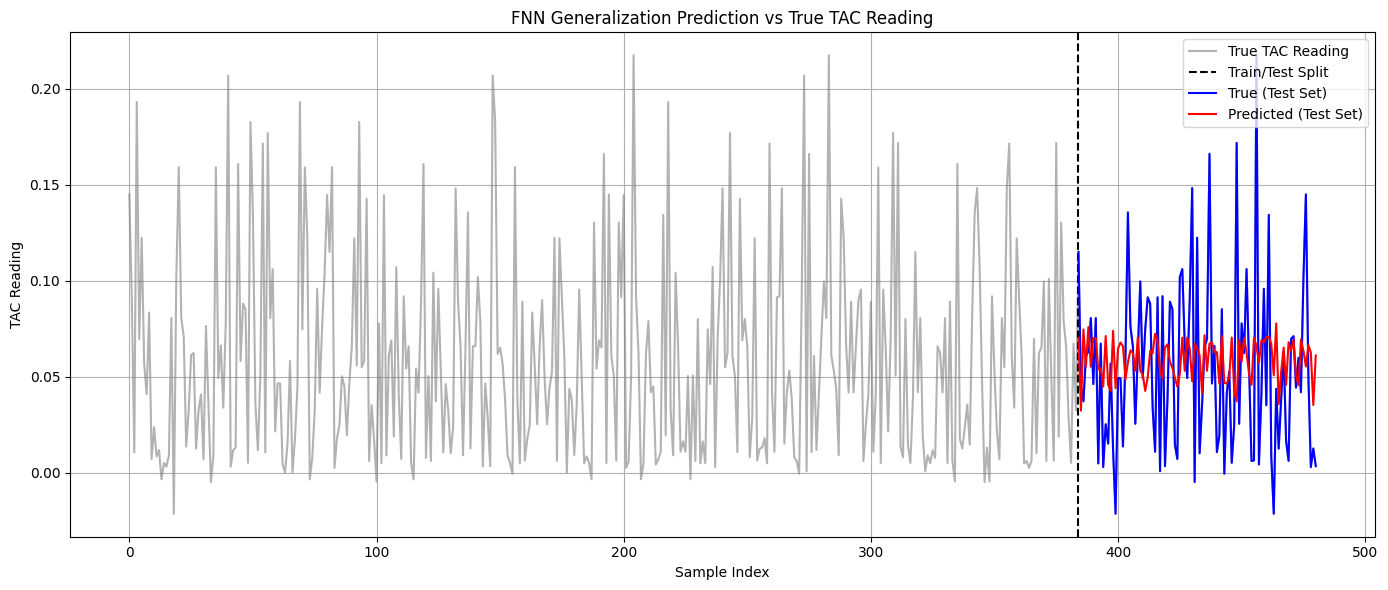


Training RNN with validation for 300 epochs...
RNN - RMSE: 0.0453, MAE: 0.0358, NRMSE: 0.1896, Pearson: 0.0227, Sober Accuracy: 73.20%


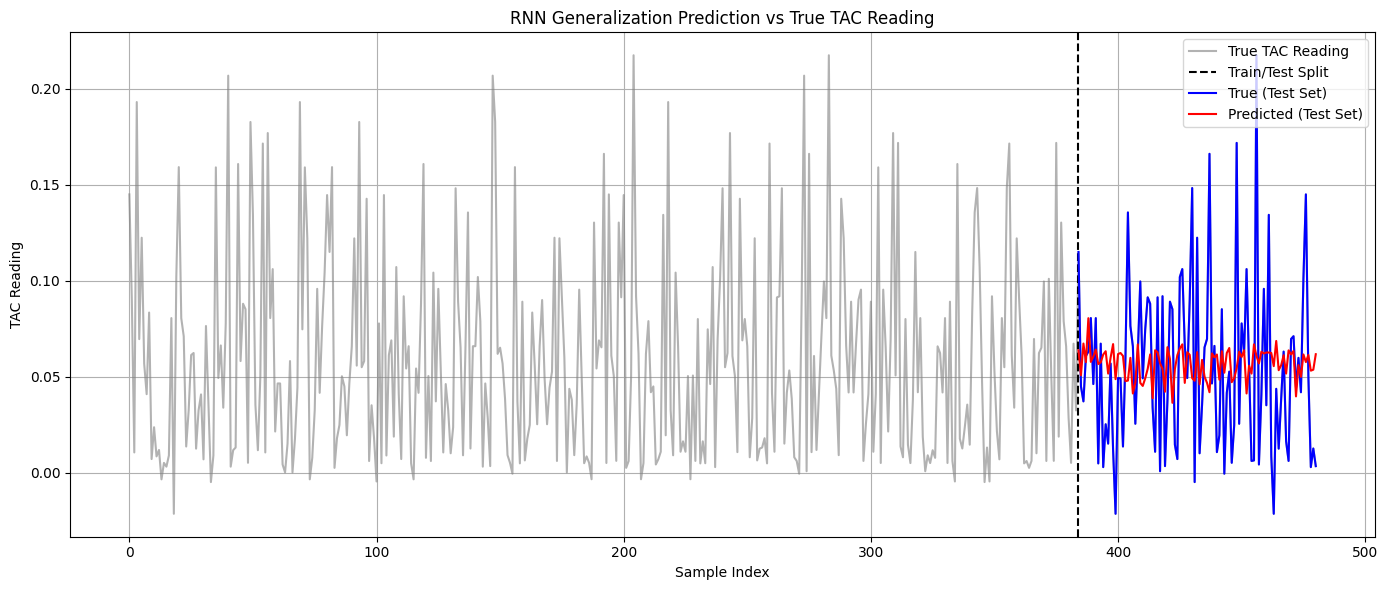


Training LSTM with validation for 300 epochs...
LSTM - RMSE: 0.0453, MAE: 0.0357, NRMSE: 0.1898, Pearson: 0.0305, Sober Accuracy: 74.23%


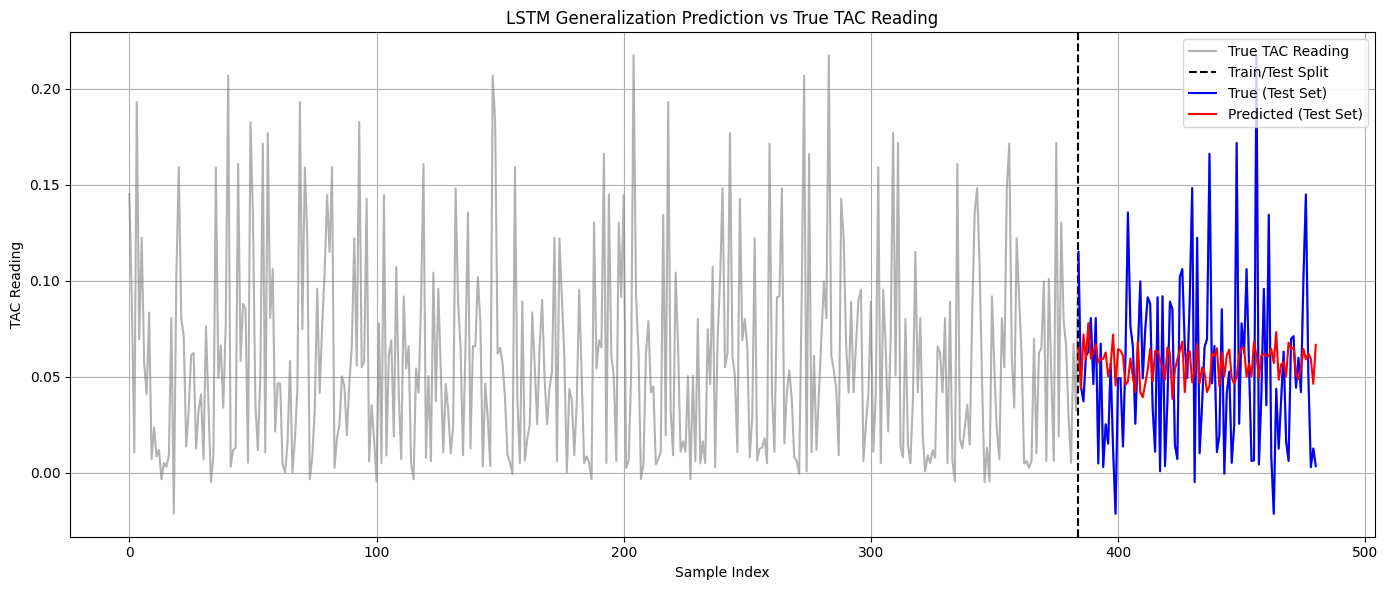


Training CNN with validation for 300 epochs...
CNN - RMSE: 0.0452, MAE: 0.0357, NRMSE: 0.1894, Pearson: 0.1055, Sober Accuracy: 73.20%


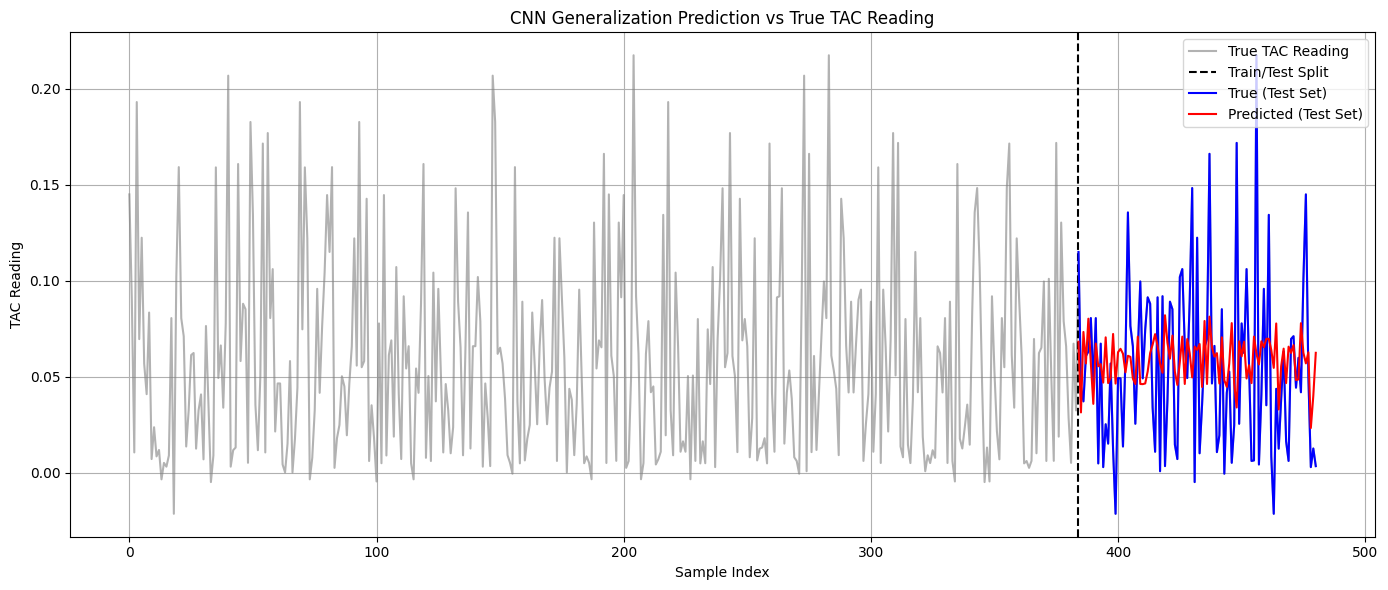

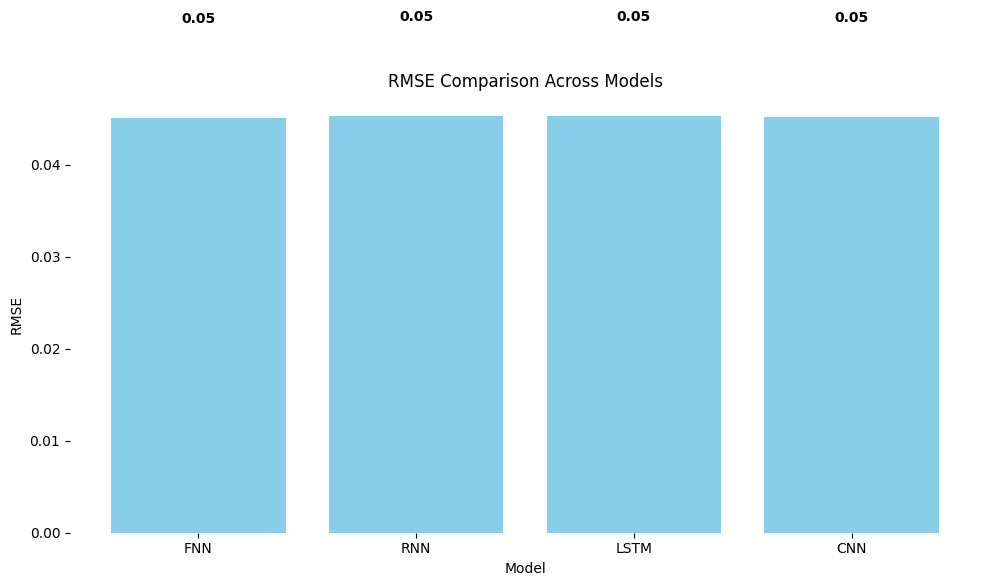

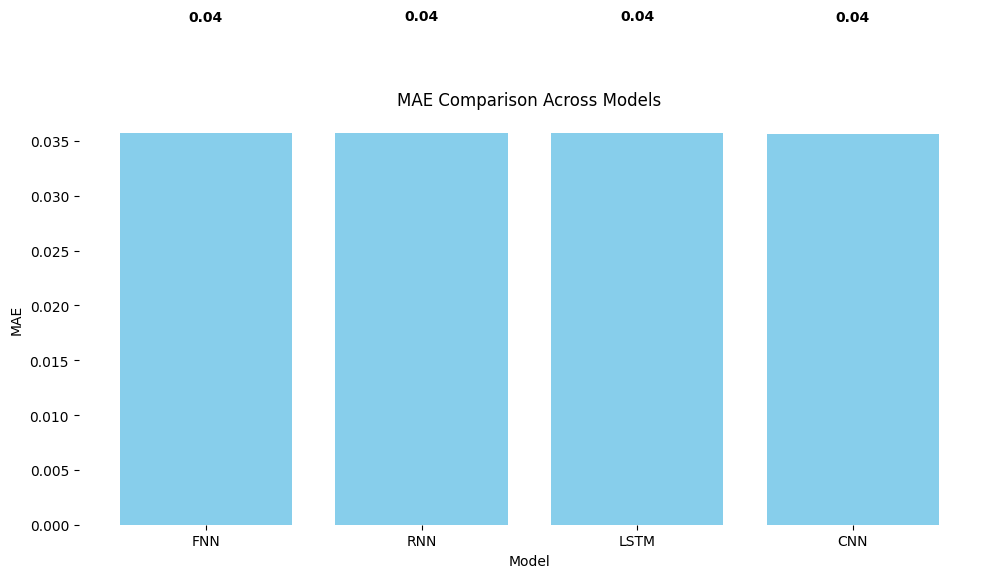

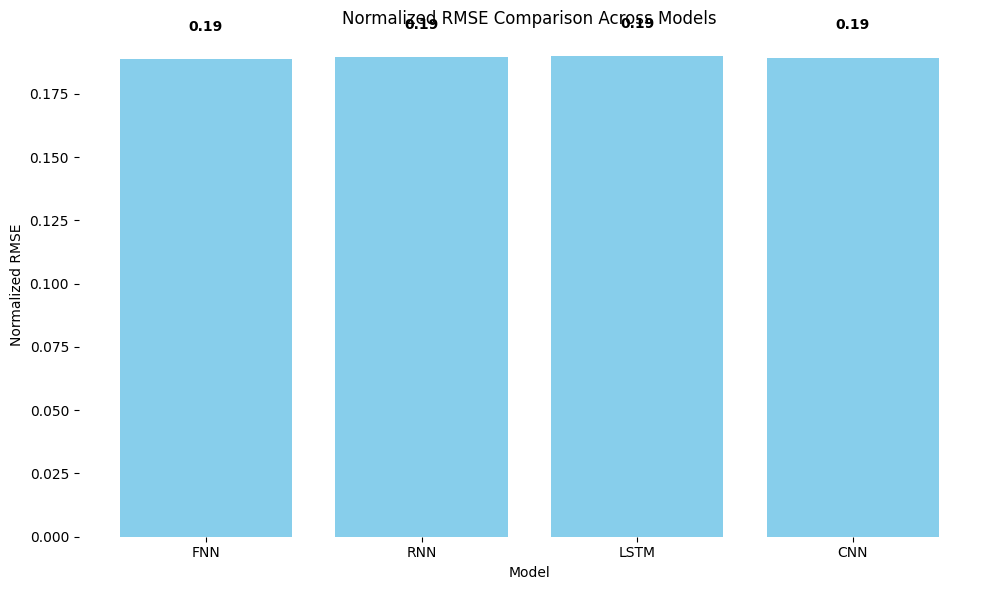

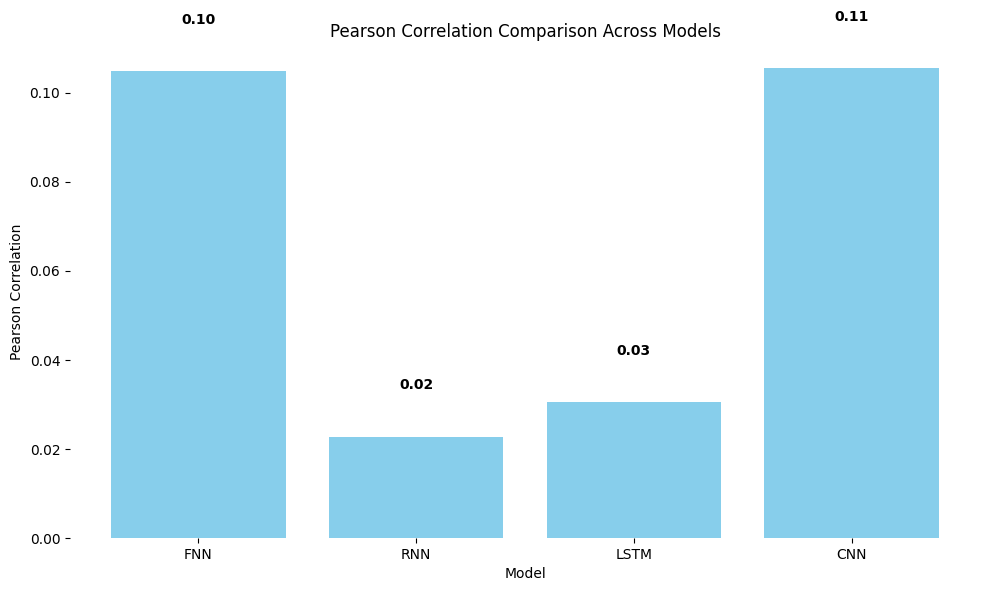

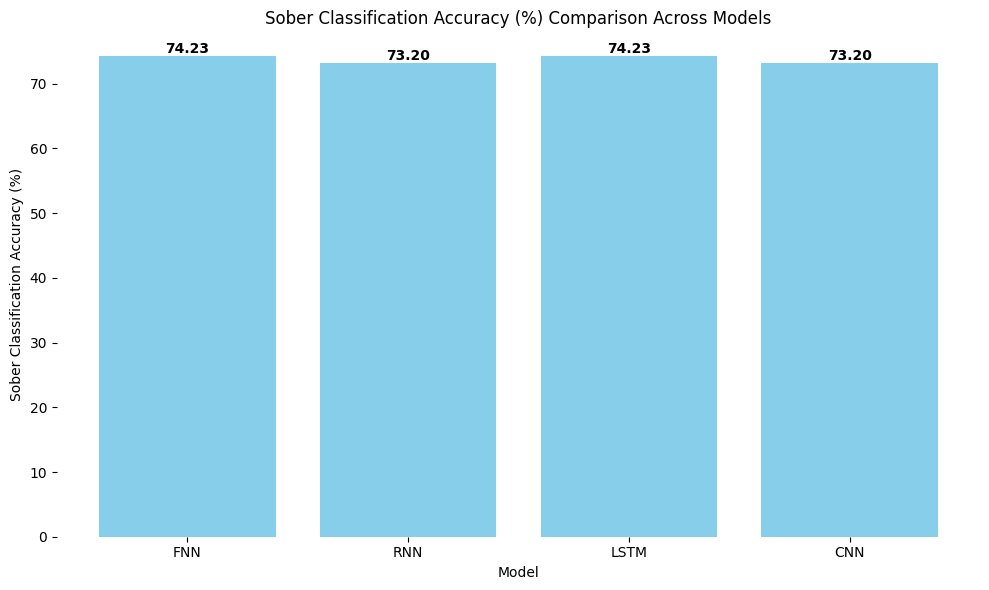

In [80]:
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=seed)
    X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

    # Define custom epochs for each model
    epochs_map = {
        'FNN': 300,
        'RNN': 300,
        'LSTM': 300,
        'CNN': 300
    }

    # Storage for comparison plots
    rmse_scores = []
    mae_scores = []
    nrmse_scores = []
    pearson_scores = []
    sober_accuracies = []
    model_names = []

    for model_name, model in models.items():
        epochs = epochs_map.get(model_name, 300)
        print(f"\nTraining {model_name} with validation for {epochs} epochs...")

        # Train and get model folder
        train_losses, test_losses, total_losses, model_folder = train_model_with_validation(
            model, X_train, y_train, X_test, y_test, model_name, epochs=epochs
        )

        # Evaluate on test set
        with torch.no_grad():
            model.eval()
            y_pred = model(X_test)
            y_pred_cpu = y_pred.detach().cpu().numpy().flatten()
            y_test_cpu = y_test.detach().cpu().numpy().flatten()

            # Calculate metrics
            rmse = calculate_rmse(y_test_cpu, y_pred_cpu)
            mae = calculate_mae(y_test_cpu, y_pred_cpu)
            nrmse = calculate_normalized_rmse(y_test_cpu, y_pred_cpu)
            pearson_corr = calculate_pearson(y_test_cpu, y_pred_cpu)
            sober_accuracy = calculate_sober_classification_accuracy(y_test_cpu, y_pred_cpu)

            # Print and store
            print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, NRMSE: {nrmse:.4f}, Pearson: {pearson_corr:.4f}, Sober Accuracy: {sober_accuracy:.2f}%")

            rmse_scores.append(rmse)
            mae_scores.append(mae)
            nrmse_scores.append(nrmse)
            pearson_scores.append(pearson_corr)
            sober_accuracies.append(sober_accuracy)
            model_names.append(model_name)

            # Save predictions vs actuals
            pd.DataFrame({
                'True_TAC': y_test_cpu,
                'Predicted_TAC': y_pred_cpu,
                'True_Sober': (y_test_cpu > 0.08).astype(int),
                'Predicted_Sober': (y_pred_cpu > 0.08).astype(int)
            }).to_csv(f"{model_folder}/predictions_vs_actuals.csv", index=False)

            # Save metrics to CSV
            metrics_df = pd.DataFrame([{
                'RMSE': rmse,
                'MAE': mae,
                'NRMSE': nrmse,
                'Pearson Correlation': pearson_corr,
                'Sober Classification Accuracy (%)': sober_accuracy
            }])
            metrics_df.to_csv(f"{model_folder}/metrics.csv", index=False)

            # Save prediction plot
            plot_predictions_with_boundary(y_train, y_test, y_pred, model_name)

    # Plot histograms across all models
    plot_metric_histogram(rmse_scores, 'RMSE', model_names)
    plot_metric_histogram(mae_scores, 'MAE', model_names)
    plot_metric_histogram(nrmse_scores, 'Normalized RMSE', model_names)
    plot_metric_histogram(pearson_scores, 'Pearson Correlation', model_names)
    plot_metric_histogram(sober_accuracies, 'Sober Classification Accuracy (%)', model_names)

